## Going9 : 세그멘테이션 알아보기

## 9-1 세그멘테이션 종류

이미지 내에서 영역을 분리하는 접근 방식은 크게 두 가지 방식이 있다. 

바로 `시맨틱 세그멘테이션(semantic segmentation)` 과 `인스턴스 세그멘테이션(instance segmentation)`이다.


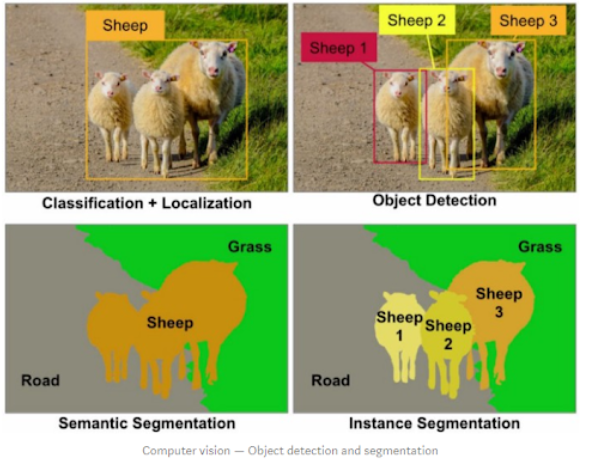


좌상단을 보면 영역의 위치를 `인식(localization)`과 물체가 양이라는 것을 `판별(classification)`하는 접근법이다. 이처럼 풀밭의 영역을 정확히 구분하지만 양들에 대해서는 각각 구분해 내지 못하는 접근 방식을 `시멘틱 세그멘테이션`이라고 한다.


우상단을 보면 개별 양들의 개체 하나하나의 위치를 정확히 식별하는 `객체 인식(object detection)`의 접근법이 추가되었다. 이처럼 각 양들의 개체 영역을 픽셀 단위로 정확히 구분해내는 접근 방식을 `인스턴스 세그멘테이션`이라고 한다.



### 1) 시맨틱 세그멘테이션(Semantic Segmentation)

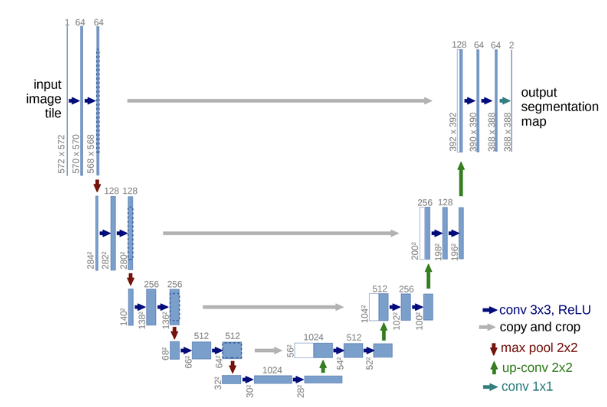

위 모델 구조는 시맨틱 세그멘테이션의 대표적인 모델인 U-Net이다. 간단히 구조만 살펴보자면, 입력으로 572x572 크기인 이미지가 들어가고 출력으로 388x388의 크기에 두 가지의 클래스를 가진 세그멘테이션 맵(segmentation map)이 나옵니다. 두 가지 클래스는 가장 마지막 레이어의 채널 개수가 "2"라는 점에서 확인할 수 있습니다.

이때 두 가지의 클래스를 문제에 따라 다르게 정의하면 클래스에 따른 시맨틱 세그멘테이션 맵(semantic segmentation map) 을 얻을 수 있습니다. 처음 봤던 예제의 인물사진 모드라면 사람의 영역과 배경 클래스를, 의료 인공지능에서는 세포 사진에서 병이 있는 영역과 정상인 영역 등을 지정해 적용할 수 있습니다.

이전에 우리가 봤던 이미지 분류나 물체 검출 문제보다 확실히 큰 출력값을 볼 수 있는데요. 그 이유는 세그멘테이션을 위해서 이미지의 각 픽셀에 해당하는 영역의 클래스별 정보가 필요하기 때문입니다.


### 2) 인스턴스 세그멘테이션(Instance Segmentation)

인스턴스 세그멘테이션은 같은 클래스 내에서도 각 개체(instance)들을 분리해서 세그멘테이션을 수행한다. 


물체 검출(object detection) 모델로 각 개체를 구분하고 이후에 각 개체 별로 시맨틱 세그멘테이션을 수행하면 인스턴스 세그멘테이션을 할 수 있지 않을까? 라는 생각으로 만든 방식 중 하나로 `Mask R-CNN`이 있다.

2017년에 발표된 `Mask-R-CNN`은 `2-Stage Object Detection의 가장 대표적인 Faster-R-CNN을 계승한 것`으로서, Faster-R-CNN의 아이디어인 Region of Interest Pooling Layer(RoIPool) 개념을 개선하여 정확한 Segmentation에 유리하게 한 `1️⃣RoIAlign`, 그리고 `️⃣클래스별 마스크 분리` 라는 단순한 두 가지 아이디어를 통해, 클래스별 Object Detection과 시멘틱 세그멘테이션을 사실상 하나의 Task로 엮어낸 것으로 평가받는 중요한 모델이다.


하지만 이 RoiPool Layer에서는 `Quantization`이 필요해서 문제가 발생하게된다. 이로 인해 Roi 영역과 픽셀이 맞지않으면 Roi 영역 밖이 포함될 수도 있고 자투리 영역이 버려지기도 한다. 그래서 필연적으로 시맨틱 세그멘테이션의 정보손실과 왜곡이 일어난다고 한다.



`Mask-R-CNN의 RoIAlign`은 Quantization하지 않고도 RoI를 처리할 고정 사이즈의 Feature map을 생성할 수 있게 아이디어를 제공한다.


아이디어의 핵심은, RoI 영역을 pooling layer의 크기에 맞추어 등분한 후, RoIPool을 했을 때의 quantization 영역 중 가까운 것들과의 bilinear interpolation 계산을 통해 생성해야 할 Feature Map을 계산해 낸다는 점이다.


그래서 Mask R-CNN은 Faster R-CNN에서 특성 추출방식을 `RoiAlign`방식으로 개선하고 세그멘테이션을 더한 방식이다. U-Net처럼 피처 맵의 크기를 키워서 마스트(mask)를 생성해 내는 부분을 통해서 인스턴스에 해당하는 영역, 즉 인스턴스 맵을 추론한다. 그래서 `Mask R-CNN`은 클래스에 따른 마스크를 예측할 때, 여러 가지 태스크를 한 모델로 학습해서 물체 검출의 성능을 높힌다.


1. Bounding box regression을 하는 Bbox head와 마스크를 예측하는 Mask Head의 두 갈래로 나뉘는 것을 볼 수 있다.  


2. Mask map의 경우 시맨틱 세그멘테이션과 달리 상대적으로 작은 28x28의 특성 맵 크기를 갖는다.  


3. RoIAlign을 통해 줄어든 특성에서 마스크를 예측하기 때문에 사용하려는 목적에 따라서 정확한 마스크를 얻으려는 경우에는 부적합할 수 있다. 

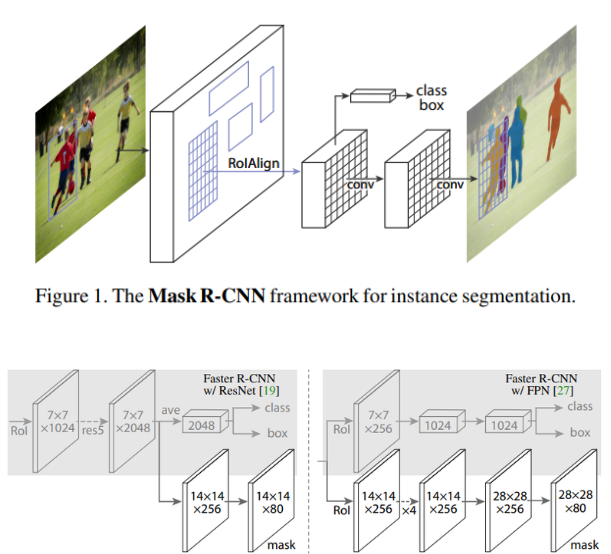

## 9-3 주요 세그멘테이션 모델 (1) FCN

### 1) FCN(Fully Convolutional Network)

FCN은 이미지넷 챌린지(ImageNet Challenge)에서 좋은 성적을 거두었던 AlexNet, VGG-16 등의 모델을 세그멘테이션에 맞게 변형한 모델이다.


기본적인 VGG 모델은 이미지의 특성을 추출하기 위한 네트워크의 뒷단에 fully connected layer를 붙여서 계산한 클래스별 확률을 바탕으로 이미지 분류를 수행한다. FCN에서는 세그멘테이션을 하기 위해서 네트워크 뒷단에 fully connected layer 대신 CNN을 붙여준다.


fully connected layer대신 CNN을 붙혀주는 이유는 뭘까 ?
- CNN은 이미지 내 위치의 특성을 유지하지만 fully connected layer는 위치를 고려하지 않기 때문이다. 위치정보를 유지하면서 클래스 단위의 히트맵을 얻어서 세그멘테이션을 하기 위해서 CNN으로 대체했다고 한다.  


마지막 CNN은 어떤 세팅을 가질까?
- 위치 특성을 유지하면서 이미지 분류를 하기 위해 마지막 CNN은 `1x1 커널 크기(kernel size)와 클래스의 개수만큼의 채널`을 갖게된다. 이렇게 CNN을 거치면 클래스 히트맵을 얻을 수 있다.  


CNN과 pooling 레이어를 거치면서 크기가 줄어든 히트맵 크기를 키워주기 위한 방법으로는 `upsampling`이 있다. 

그중에서도 FCN에서는 `Deconvolution`과 `Interpolation` 방식을 활용하는데 `Deconvolution`은 컨볼루션 연산을 거꾸로 해준 것이라고 볼 수 있다. `Interpolation`은 보간법으로 주어진 값들을 통해서 추정해야하는 픽셀을 추정하는 방식이다.


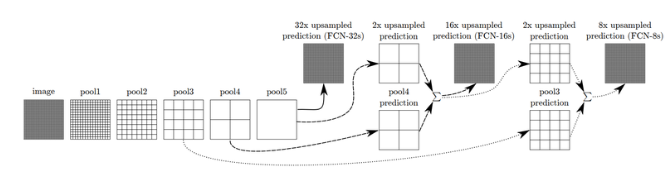

그래서 Upsampling을 하면 원하는 세그멘테이션 맵을 얻을 수 있다. 


하지만 논문에서는 더 나은 성능을 위해서 한가지 기법을 더해주는데 위에서 볼 수 있듯이 `Skip Architecture`라는 방법이다. 

앞쪽 블록에서 얻은 예측 결과 맵과 2배로 upsampling한 맵을 더하고 한번에 16배로 upsampling을 해서 얻는다. 여기서 한번 더 앞쪽 블록을 사용하면 FCN-8s를 얻을 수 있다. 이 기법으로 나아지는 결과는 아래를 참고하자.

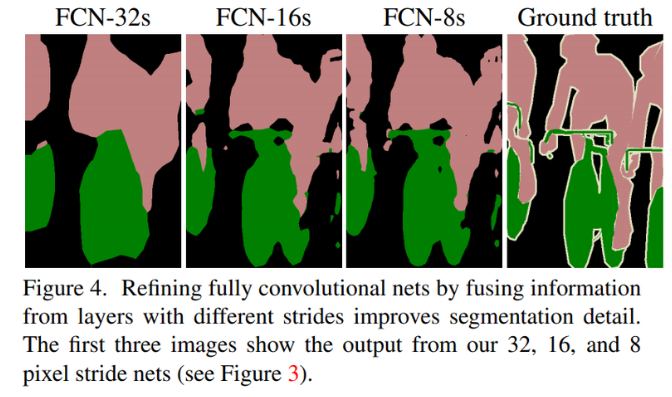

## 9-4. 주요 세그멘테이션 모델 (2) U-Net

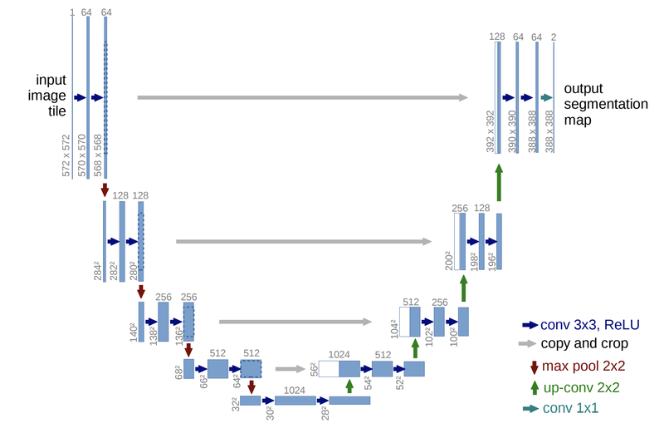

U-Net은 이름에서 볼 수 있듯이 네트워크 구조가 U자 형태를 띠고 있다. 

`FCN에서 upsampling을 통해서 특성 맵을 키운 것을 입력값과 대칭적으로 만들어 준 것`이다. 특이한 점으로는 본래 의학 관련 논문으로 시작되었다고 한다. 세포의 영역을 세그멘테이션 하기 위해서 개발된 방법이라고 한다.


### 전체 구조

논문에서 보면 네트워크 구조를 좌측의 `Contracting path`와 우측의 `Expansive path` 두가지로 구분한다.

`좌측 Contracting path`는 일반적으로 사용해왔던 Convolution network와 유사한 구조를 가진다. 각 블록은 두 개의 3x3 convolution 계층과 ReLu를 가지고 그 뒤로 downsampling을 거치고 다음 convolution의 채널 크기는 두 배씩 늘어나도록 설계되었다.


`Expansive path`에서는 각 블록에 2x2 up-convolution이 붙어서 채널이 절반씩 줄어들고 특성 맵의 크기는 늘어난다. Expansive path의 블록은 contracting block과 동일하게 3x3 convolution이 두 개씩 사용되었다.


두 Path에서 크기가 같은 블록의 출력과 입력은 `skip connected처럼 연결해줘서 low-level의 feature를 활용`할 수 있도록 했다. 마지막에는 1x1 convolution으로 원하는 시맨틱 세그멘테이션 맵을 얻을 수 있다.


결과적으로 입력으로 572x572 크기인 이미지가 들어가고 출력으로 388x388의 크기에 두 가지 클래스를 가진 세그멘테이션 맵(segmentation map)이 나오게 된다.


마지막 세그멘테이션 맵의 크기가 입력 이미지와 다른 것은 앞에서 얘기한 것처럼 세그멘테이션 맵을 원하는 크기로 조정해서 해결할 수 있다. 원본 이미지와 맞게 크기를 조정해주면 위에서 봤던 우리가 원하는 시맨틱 세그멘테이션 결과를 얻을 수 있다.


### 타일(Tile) 기법

U-Net이 downsampling과 upsampling(또는 인코딩과 디코딩)을 대칭으로 하는 점은 구조에서 한눈에 파악이 가능하다. 또 다른 차이로는 세그멘테이션 맵의 해상도이다. FCN은 입력 이미지의 크기를 조정해서 세그멘테이션 맵을 얻어냈다. 반면에 U-Net은 타일(tile) 방식을 사용해서 어느정도 서로 겹치는 구간으로 타일을 나누어서 네트워크를 추론, 큰 이미지에서도 높은 해상도의 세그멘테이션 맵을 얻을 수 있도록 했다.


### 데이터 불균형 해결

세포를 검출해내기 위해서 세포들의 영역 뿐만 아니라 경계 또한 예측을 해야하는데 이때 픽셀 단위로 라벨을 매긴다고 생각하면 데이터셋을 세포나 배경보다는 절대적으로 세포간 경계의 면적이 작을 것이다. 이러한 `클래스 간 데이터 양의 불균형을 해결`해주기 위해서 분포를 고려한 `weight map`을 학습 때 사용했다고 한다.

여기서 weight는 신경망의 학습 파라미터가 아니고 `손실함수(loss)에 적용되는 가중치를 말한다.` 의료 영상에서 상대적으로 면적이 작은 세포 경계를 명확하게 추론해 내는 것이 더욱 중요하기 때문에 세포 경계의 손실에 더 많은 페널티를 부과하는 방식이다.

## 9-5. 주요 세그멘테이션 모델 (3) DeepLab 계열

처음 DeepLab 모델이 제안된 뒤 이 모델을 개선하기 위해서 Atrous Convolution와 Spatial Pyramid Pooling 등 많은 방법들이 제안되어 왔었다. DeepLab3+의 전체 구조를 보고 Dilated Convolution이라고 불리는 Atrous Convolution과 Spatial Pyramid Pooling을 살펴보도록 한다.


### 전체 구조

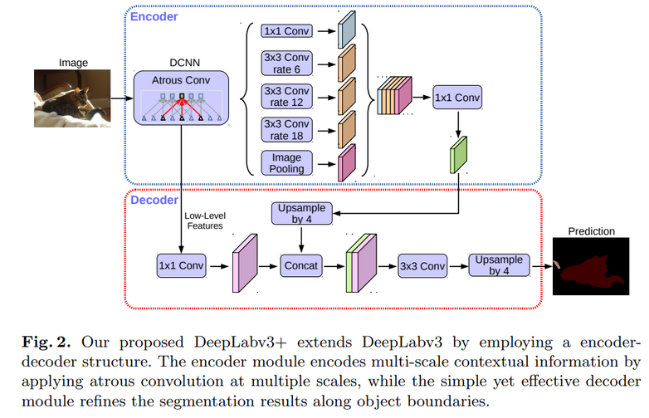

위 그림이 DeepLab3+이다. U-Net에서의 Contracting path과 Expansive path의 역할을 하는 것이 여기서는 위 그림의 인코더(Encoder), 디코더(Decoder)이다.

인코더는 이미지에서 필요한 정보를 특성으로 추출해 내는 모듈이고 디코더는 추출된 특성을 이용해서 원하는 정보를 예측하는 모듈이다. 3x3 convolution을 사용했던 U-Net과 다르게 DeepLab V3+는 Atrous Convolution을 사용한다. 그리고 Atrous Convolution을 여러 크기에 다양하게 적용한 것이 ASPP(Atrous Spatial Pyramid Pooling)이다. DeepLab V3+는 ASPP가 블록을 통해서 특성을 추출하고 디코더에서 Upsampling을 통해서 세그멘테이션 마스크를 얻고 있다.

### Atrous Convolution

Atrous Convolution은 간단히 말해 `띄엄띄엄 보는 컨볼루션`이다. 일반적인 컨볼루션과 다르게 더 넓은 영역을 보도록 해주기 위한 방법으로 커널이 일정 간격으로 떨어져 있다. 이를 통해서 컨볼루션 레이어를 너무 깊게 쌓지 않아도 넓은 영역의 정보를 커버할 수 있게 된다.

### Spatial Pyramid Pooling

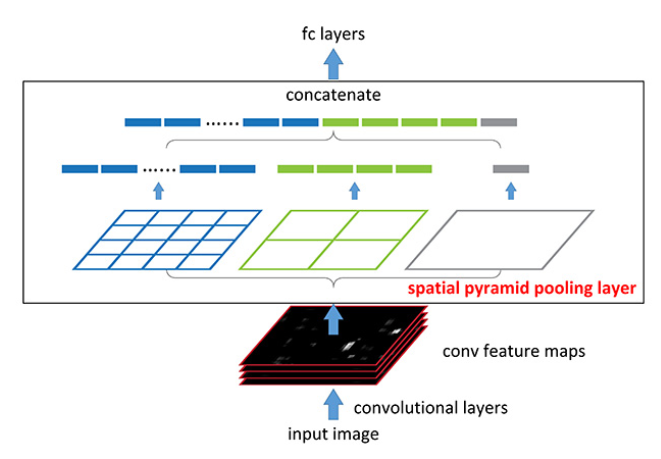

위 그림만으로도 직관적으로 이해할 수 있는 Spatial Pyramid Pooling은 여러 가지 스케일로 convolution과 pooling을 하고 나온 다양한 특성을 연결(concatenate)해준다. 이를 통해서 멀티스케일로 특성을 추출하는 것을 병렬로 수행하는 효과를 얻을 수 있다. 여기서 컨볼루션을 Atrous Convolution으로 바꾸어 적용한 것은 Atrous Spatial Pyramid Pooling이라고 한다. 이러한 아키텍처는 입력 이미지의 크기와 관계없이 동일한 구조를 활용할 수 있다는 장점이 있다. 고로 제각기 다양한 크기와 비율을 가진 Roi 영역에 대해 적용하기 유리하다.

## 9-6. 세그멘테이션의 평가

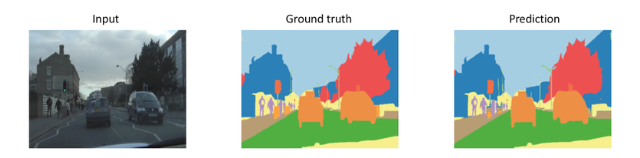

시멘틱 세그멘테이션의 결과값은 `이미지의 크기에 맞는 세그멘테이션 맵 크기`와 `시맨틱 클래스의 수에 맞는 채널 크기`를 갖는다. 여기서 각 채널의 max probability에 따라 해당 위치의 클래스가 결정된다.

### 1) 픽셀별 정확도 (Pixel Accuracy)

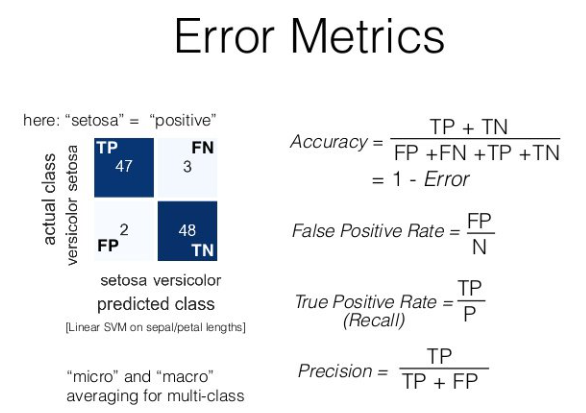

Pixel Accuracy는 쉽게 말해서 픽셀에 따른 정확도를 의미한다.

세그멘테이션 문제를 픽셀에 따른 이미지 분류 문제로 생각했을 때 우리는 이미지 분류 문제와 비슷하게 픽셀별 분류 정확도를 세그멘테이션 모델을 평가하는 기준으로 생각할 수 있다.

예측 결과 맵(prediction map)을 클래스 별로 평가하는 경우에는 이진 분류 문제(binary classification)으로 생각해서 픽셀 및 채널 별로 평가한다. 픽셀 별 이미지 분류 문제로 평가하는 경우에는 픽셀 별로 정답 클래스를 맞췄는지 여부 (True/False)를 구분한다.

예를 들자면 4x4의 크기를 가지는 map에서 중앙의 2x2 영역이 전경이고 예측 결과 중 한칸을 놓쳤다. 이때 위에서 보이는 Error Metrics를 확인하면 (TP+TN)/(FP+FN+TP+TN)으로 Accuracy를 구할 수 있다. TP(True positive) + TN(True negative)는 옳게 분류된 샘플의 수로 잘못 예측된 한 칸을 제외한 15이다. 그리고 False case는 1인 한 칸은 전경이 배경으로 예측되었으니 FN(False negative)이다. 따라서 분모항은 16이 된다. 따라서 Pixel Accuracy는 15/16으로 계산할 수 있다.


### 2) 마스크 IoU ( Mask Intersection-over-Union)

물체 검출 모델을 평가할 때는 정답 라벨(ground truth)와 예측 결과 바운딩 박스(prediction bounding box) 사이의 IoU(intersection over union)을 사용한다. 마스크도 일종의 영역임을 생각한다면 세그멘테이션 문제에서는 정답인 영역과 예측한 영역의 IoU를 계산할 수 있다. 아래 식은 세그멘테이션 마스크의 IoU를 계산하는 식이다. 

```
# sample for mask iou
intersection = np.logical_and(target, prediction)
union = np.logical_or(target, prediction)
iou_score = np.sum(intersection) / np.sum(union)
```

마스크 IoU를 클래스 별로 계산하면 한 이미지에서 여러 클래스에 대한 IoU 점수를 얻을 수 있다. 이를 평균하게 되면 전체적인 시맨틱 세그멘테이션 성능을 가늠할 수 있다.

## 9-7. Upsampling의 다양한 방법

Segmentation에서는 마스킹 단계에 Upsampling이 중요하게 사용되었다는 것을 알 수 있는데 Convolution layer와 다양한 Pooling 등으로 Feature의 크기를 줄여왔는데, 반대로 키우는 방법은 뭐가 있는지 알아보자.

### 1) Nearest Neighbor

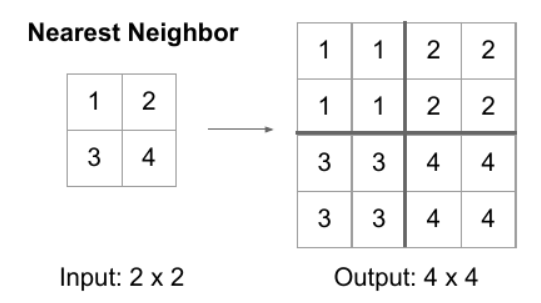

Nearest upsampling은 이름 그대로 scale을 키운 위치에서 원본에서 가장 가까운 값을 그대로 적용하는 방법이다. 위 그림처럼 2x2 matrix가 있을 때 이를 2배로 키우게 되면 4x4의 matrix가 된다. 이때 좌측 상단으로부터 2x2는 입력 matrix의 1x1과 가장 가깝다. 따라서 해당 값을 그대로 사용한다.


### 2) Bilinear Interploation

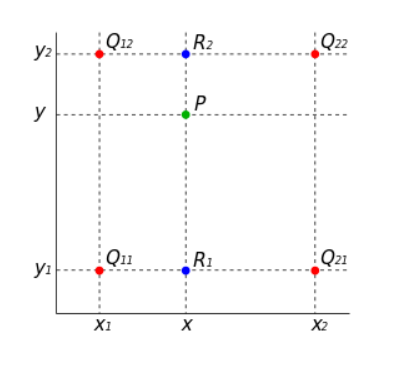


Bilinear Interpolation은 두 축에 대해서 선형보간법을 통해서 필요한 값을 메우는 방식이다. 우리가 2x2 matrix를 4x4로 upsampling을 할때 이미지처럼 빈 값을 채워야한다. 이에 선형보간법(Linear interpolation)을 사용하는 것인데 이때 축을 두 방향으로 활용하기 때문에 Bilinear nterpolation이라고 한다.

위 그림에서 두 가지 interpolation을 적용한 것을 순서대로 확인할 수 있는데요. R(1)이 Q(11)과 Q(21)의  x축방향의 interpolation 결과입니다. 그리고 R(2)는 Q(12)와 Q(22)의 x축방향의 interpolation 결과입니다. 그리고 R(1)과 R(2)를 y축방향으로 interpolation하면 새로운 위치 PP의 값을 추정할 수 있습니다. 이러한 선형 보간 방법으로 Interpolation을 하는 방법이 있고 Bicubic interpolation의 경우 삼차보간법을 사용합니다.

(선형보간법과 삼차보간법)
https://bskyvision.com/m/789


### 3) Transposed Convolution

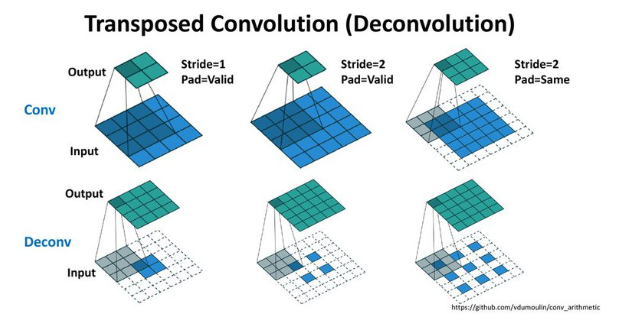

지금까지 봤던 방식은 정해진 규칙에 따라서 upsampling하는 방법들을 봤다. 그렇다면 학습할 수 있는 파라미터를 가진 Upsampling 방법이 있을까 하는 생각을 가질 수 있는데 Transposed Convolution이 그 방법 중 하나이다. 우리가 사용해왔던 Convolution Layer는 Kernel의 크기를 정의하고 입력된 Feature를 Window에 따라 output을 계산한다. Transposed Convolution은 이와 반대 연산을 한다. 따라서 거꾸로 학습된 파라미터로 입력된 벡터를 통해서 더 넓은 영역의 값을 추정해낸다. 

(상세한 과정)
https://zzsza.github.io/data/2018/06/25/upsampling-with-transposed-convolution/